In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from datetime import datetime
import sys
import os
sys.path.append(os.path.join(sys.path[0],'KalmanNet_TSP'))
from KalmanNet_nn import KalmanNetNN
from Extended_data import DataLoader
from msc_filtering import MyKalmanFilterHigherOrder, run_filter
from gen_dataset import gen_dataset

## Neual kalman filtering

#### Dataset read

In [2]:
[train_input, train_target, cv_input, cv_target, test_input, test_target] = DataLoader('./datasets/para.pt')

In [3]:
sequence_no = 99
plot_data = test_input[sequence_no][0].cpu().numpy()
plot_gt = test_target[sequence_no][0].cpu().numpy()
steps = np.arange(plot_data.shape[0])

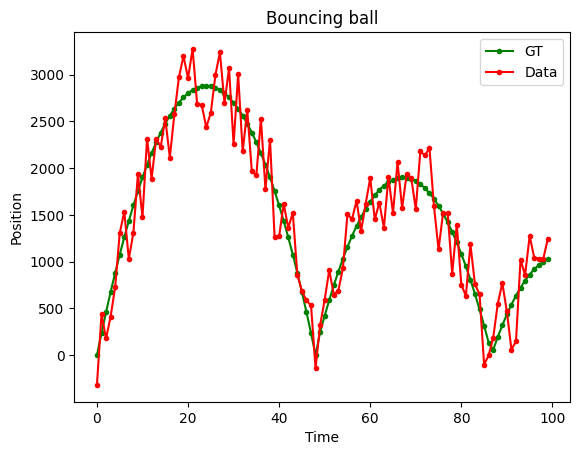

In [4]:
plt.plot(steps, plot_gt ,marker=".",color="green")
plt.plot(steps, plot_data,marker=".",color="red")
plt.title("Bouncing ball")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["GT", "Data"],loc='upper right')
plt.show()

#### Appy first order kalman

In [5]:
delta_t = 1

In [6]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.001
# Piecewiese white noise model
# This noise model assumes white noise on the lambda state (constant over a time cycle)
Q = q*np.array([[(delta_t**4)/4, (delta_t**3)/2],
                [(delta_t**3)/2,   (delta_t**2)]])
H = np.array([1, 0])

In [7]:
firstFilter_rising = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_rising_first = run_filter(firstFilter_rising, plot_data)

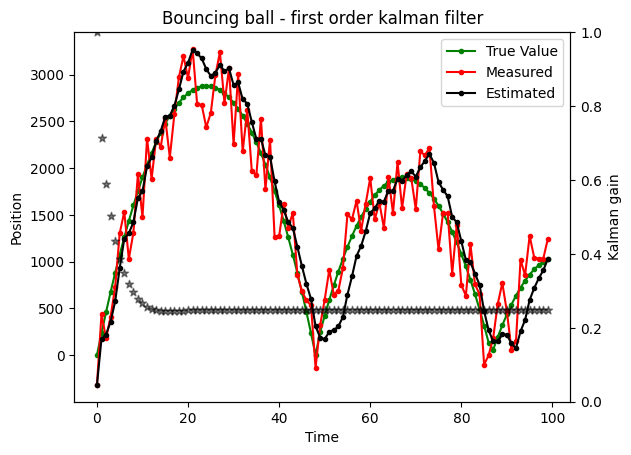

In [8]:
plt.plot(steps, plot_gt, marker=".",color="g")
plt.plot(steps, plot_data, marker=".",color="red")
plt.plot(steps, np.stack((df_rising_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.title("Bouncing ball - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["True Value","Measured","Estimated"],loc='upper right')
plt.twinx()
plt.scatter(df_rising_first.index, np.stack((df_rising_first['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black", alpha=0.5)
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

#### Try neural model

In neural kalman filtering the idea is to learn the kalman gain. 

In [9]:
dev = torch.device("cpu")
torch.cuda.is_available()

True

Load model

In [10]:
model = torch.load('./models/model_KNet_para.pt')
model.eval()

KalmanNetNN(
  (KG_l1): Linear(in_features=4, out_features=320, bias=True)
  (KG_relu1): ReLU()
  (rnn_GRU): GRU(320, 80)
  (KG_l2): Linear(in_features=80, out_features=16, bias=True)
  (KG_relu2): ReLU()
  (KG_l3): Linear(in_features=16, out_features=4, bias=True)
  (sig_l3): Sigmoid()
)

Initialiase

In [11]:
model.InitSequence(torch.tensor([[0],[0]], dtype=torch.float32))
model.init_hidden()

Process a data sequence

In [12]:
res = []
k_ = []
t_ = []
for step, item in enumerate(test_input[sequence_no].T):
    #inp = torch.tensor([item,0],dtype=torch.float32)
    #out = model.forward(inp.float())
    out = model.forward(item)
    res.append(out.cpu().detach().numpy()[0])
    k_.append(model.KGain.cpu().detach().numpy()[0][0])
    t_.append(step)

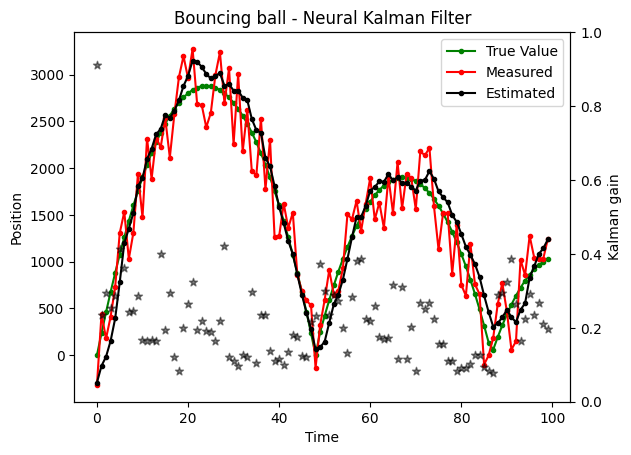

In [13]:
plt.plot(t_, test_target[sequence_no][0].cpu().detach().numpy() ,marker=".",color="g")
plt.plot(t_, test_input[sequence_no][0].cpu().detach().numpy() ,marker=".",color="red")
plt.plot(t_, res ,marker=".",color="black")
plt.title("Bouncing ball - Neural Kalman Filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["True Value", "Measured","Estimated",],loc='upper right')
plt.twinx()
plt.scatter(t_, k_,marker="*",color="black", alpha=0.5)
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

Initally the gain is high - this indicates that the model has learnt an initialisation behavior. Varying measurements and model steps may improve lag? Performs better than random

#### Performance comparrision

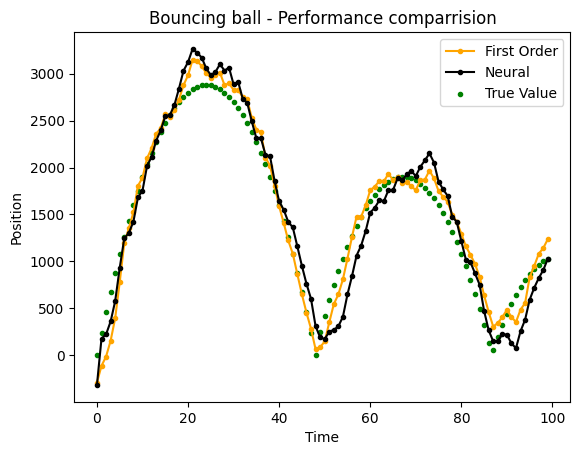

In [14]:
plt.plot(t_, res ,marker=".",color="orange")
plt.plot(df_rising_first.index, np.stack((df_rising_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.scatter(df_rising_first.index, test_target[sequence_no][0].cpu().detach().numpy() ,marker=".",color="g")
plt.title("Bouncing ball - Performance comparrision")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["First Order","Neural","True Value"],loc='upper right')
plt.show()

#### Improvement proposals

- Apply gravity in model as a constant control signal
- Apply augmentations to dataset (rolling shift, DC shift)
- Investigate different input signals
- Try to add additional complexity to network 